<a href="https://colab.research.google.com/github/compartia/nlp_tools/blob/tensorflow-model/notebooks/Search_patterns_right_in_TF_(solo_session).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A model 💎 for finding closest embedding to a pattern
1. At first stage, we calculate attention vectors (AV) for every pattern
2. Then, for each AV we're finding the closest point (`best point`) in text embedding space, 
3. Then we're calculating "improved" vectors -- we calculate distance from the `"best point"` (actually, from the best *window*)  to each point in text embedding space.  
  
WARNING: this should be used only if `best point` is close enough to the pattern

In [0]:
GLOBALS__={}

## MAIN, init, load code

In [3]:
#@title  { form-width: "300px", display-mode: "form" }
import os






# ''' AZ:-IMPORT CODE GITHUB----------------------------------------------😺------ '''
import sys
# ====================================
# ====================================
_git_branch = "tensorflow-model"  # @param {type:"string"}
# ====================================
# ====================================


def _init_import_code_from_gh():
  if 'GLOBALS__' not in globals():
    print('adding global GLOBALS__')
    global GLOBALS__
    GLOBALS__ = {}

  if '_init_import_code_from_gh' in GLOBALS__:
    print('👌 code already imported from GitHub!')
    return

  import subprocess
  def exec(x):
    r = subprocess.check_output(x, shell=True)
    r = r.decode('unicode-escape').encode('latin1').decode('utf8')
    print(r)

  print(f"fetching code from GitHub.....{_git_branch}")
  try:
    exec('rm -r nlp_tools')
  except:
    pass
  exec(f'git clone --single-branch --branch {_git_branch} https://github.com/compartia/nlp_tools.git nlp_tools')

  print('🦊 GIT revision:')
  exec('cd nlp_tools\ngit rev-list --reverse HEAD | awk "{ print NR }" | tail -n 1\ngit branch\ngit log -3 --pretty=%B')

  sys.path.insert(0, 'nlp_tools')

  # self-test
  from text_tools import untokenize
  print(untokenize(['code', 'imported', 'OK 👍']))

  print('installing antiword...')
  exec('sudo apt-get install antiword')

  print('installing docx2txt...')
  exec("pip install docx2txt")

  GLOBALS__['_init_import_code_from_gh'] = True

  ''' AZ:-------------------------------------------------IMPORT CODE GITHUB-😺---'''
  print('❤️ DONE importing Code fro GitHub')


# AZ:-INIT ELMO-----------------------------------------------------------------------------------

import tensorflow_hub as hub

#
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML


 

# AZ:- THE CODE----------------------------------------------------------------------------------

def _init_the_code(reset=False):
  if '_init_the_code' in GLOBALS__ and not reset:
    print('👌 Code is alredy imported!')
    return

  from renderer import HtmlRenderer
  from renderer import to_multicolor_text
  from renderer import known_subjects_dict

  from structures import ContractSubject
  from contract_parser import ContractDocument3

  from ml_tools import ProbableValue

  from legal_docs import LegalDocument
  from renderer import as_warning, as_headline_3, as_offset, as_smaller

  class DemoRenderer(HtmlRenderer):

    def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      html = self.to_color_text(tokens, weights, colormap, print_debug, _range)
      display(HTML(html))

    def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None):
      return super()._to_color_text(tokens, weights, mpl, colormap=colormap, _range=_range)

    def render_multicolor_text(self, tokens, vectors, colormap, min_color=None, _slice=None):
      display(HTML(to_multicolor_text(tokens, vectors, colormap, min_color=min_color, _slice=_slice)))

     
     

     
  GLOBALS__['renderer'] = DemoRenderer()

  # AZ:----------PROTOCOLS RENDERER-------------------------

   

 

  GLOBALS__['_init_the_code'] = True
  print("❤️ DONE initializing the code")

  # AZ:-------------------------------------------------Init Protocols context===



def interactive_upload(filetype):
  from google.colab import files
  import docx2txt

  print(f'Please select "{filetype}" .docx file:')
  uploaded = files.upload()
  docs = []
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

    with open(fn, "wb") as df:
      df.write(uploaded[fn])
      df.close()

    # extract text

    text = ''
    try:
      text = docx2txt.process(fn)
    except:
      print("Unexpected error:", sys.exc_info())
      os.system('antiword -w 0 "' + fn + '" > "' + fn + '.txt"')
      with open(fn + '.txt') as f:
        text = f.read()
    print("Символов в оригинальном документе:", len(text))
    docs.append(text)
    return docs

  
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXXX
# AZ:- ENDO OF THE THE CODE------------------------------------------------XXXX

"""# step 0. Инит"""

## do preparation here

# 1.
_init_import_code_from_gh()
 
# 3.
_init_the_code(True)



fetching code from GitHub.....tensorflow-model

🦊 GIT revision:
447
* tensorflow-model
Merge branch 'master' into tensorflow-model

# Conflicts:
#	legal_docs.py

Merge remote-tracking branch 'origin/tensorflow-model' into tensorflow-model

# Conflicts:
#	notebooks/Search_patterns_right_in_TF.ipynb

Merge pull request #36 from compartia/refactoring

↗️ Move notebooks to the separate dir

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
code imported OK 👍
installing antiword...
Reading package lists...
Building dependency tree...
Reading state information...
antiword is already the newest version (0.37-11build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.

installing docx2txt...

❤️ DONE importing Code fro GitHub
❤️ DONE initializing the code


#  Finalize TF graph for embedding 💎

In [4]:
from typing import List

import numpy as np

from fuzzy_matcher import AttentionVectors, prepare_patters_for_embedding
from patterns import FuzzyPattern
from text_tools import Tokens, hot_punkt


def make_punkt_mask(tokens: Tokens) -> np.ndarray:
  return 1.0 - 0.999 * hot_punkt(tokens)


class PatternSearchModel:


  def __init__(self, tf, hub,
               module_url='https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz'):
    self.tf = tf
    self.hub = hub
    self.module_url = module_url

    # cosine_similarities, cosine_similarities_improved
    self.embedding_session = None
    self.make_embedding_session_and_graph()

  def _center_weighted(self, x, weights):
    # todo reduce sum or reduce mean? Does not matter because we normalize it
    tf = self.tf

    _weighted = tf.multiply(x, tf.expand_dims(weights, -1, name="expanded"), name='weighted')
    _weighted_sum = self.tf.reduce_sum(_weighted, axis=0, name='weighted_sum')

    _total_weight = self.tf.reduce_sum(weights, axis=0, name='total_weight')
    return _weighted_sum / _total_weight

  def _center(self, x):
    return self.tf.reduce_mean(x, axis=0)

  def _pad_tensor(self, tensor, padding, el, name):
    tf = self.tf
    _mask_padding = tf.tile(el, padding, name='pad_' + name)
    return tf.concat([tensor, _mask_padding], axis=0, name='pad_tensor_' + name)

  def _build_graph(self) -> None:
    tf = self.tf  # hack for PyCharm because i don't want to download TF, it is provided by CoLab from UI

    # BUILD IT -----------------------------------------------------------------
    elmo = self.hub.Module(self.module_url, trainable=False)

    # inputs:--------------------------------------------------------------------
    self.text_input = tf.placeholder(dtype=tf.string, name="text_input")
    self.text_lengths = tf.placeholder(dtype=tf.int32, name='text_lengths')

    self.mask = tf.placeholder(dtype=tf.float32, name='p_weights')

    self.pattern_input = tf.placeholder(dtype=tf.string, name='pattern_input')
    self.pattern_lengths = tf.placeholder(dtype=tf.int32, name='pattern_lengths')
    self.pattern_slices = tf.placeholder(dtype=tf.int32, name='pattern_slices', shape=[None, 2])
    # ------------------------------------------------------------------- /inputs

    patterns_max_len = tf.math.reduce_max(self.pattern_lengths, keepdims=True, name='patterns_max_len')

    number_of_patterns = tf.shape(self.pattern_input)[0]

    self.mask_ext = self._pad_tensor(self.mask, patterns_max_len, tf.constant([0.001]), name='weights_padded')
    text_input_ext = [
      self._pad_tensor(self.text_input[0], patterns_max_len, tf.constant(['\n']), name='text_input_ext')]

    # 1. text embedding---------------
    # TODO: try to deal with segmented text (this is about trailing index - [0] )
    _text_embedding = self._embed(elmo,
                                  text_input_ext,
                                  [self.text_lengths[0] + patterns_max_len[0]])[0]

    # 2. patterns embedding
    _patterns_embeddings = self._embed(elmo, self.pattern_input, self.pattern_lengths)

    # for looping
    text_range = tf.range(self.text_lengths[0], dtype=tf.int32, name='text_input_range')
    patterns_range = tf.range(number_of_patterns, dtype=tf.int32, name='patterns_range')

    self.cosine_similarities = tf.map_fn(
      lambda i: self.for_every_pattern((self.pattern_lengths[i], self.pattern_slices[i], _patterns_embeddings[i]),
                                       _text_embedding, self.mask_ext,
                                       text_range), patterns_range, dtype=tf.float32, name='cosine_similarities')

    def improve_dist(attention_vector, pattern_len):
      """
        finding closest point (aka 'best point')
      """
      max_i = tf.math.argmax(attention_vector, output_type=tf.dtypes.int32)
      best_embedding_range = _text_embedding[max_i:max_i + pattern_len]  # metapattern

      return self._convolve(text_range, _text_embedding, weights=self.mask_ext, pattern_emb_sliced=best_embedding_range,
                            name='improving')

    def find_best_embeddings():
      return tf.map_fn(
        lambda pattern_i: improve_dist(self.cosine_similarities[pattern_i], self.pattern_lengths[pattern_i]),
        patterns_range, dtype=tf.float32, name="find_best_embeddings")

    self.cosine_similarities_improved = find_best_embeddings()

    unpadded_text_embedding_ = self._embed(elmo,
                                           self.text_input,
                                           [self.text_lengths[0]])[0]
    text_center = self._center_weighted(unpadded_text_embedding_, self.mask)
    self.distances_to_center = tf.map_fn(
      lambda i: self.get_matrix_vector_similarity(unpadded_text_embedding_[i:i + 1], self.mask[i:i + 1],
                                                  text_center),
      text_range, dtype=tf.float32)
    word_text_center_i = tf.math.argmax(self.distances_to_center, output_type=tf.dtypes.int32)
    word_text_center = unpadded_text_embedding_[word_text_center_i]
    self.distances_to_local_center = tf.map_fn(
      lambda i: self.get_matrix_vector_similarity(unpadded_text_embedding_[i:i + 1], self.mask[i:i + 1],
                                                  word_text_center), text_range, dtype=tf.float32)

  @staticmethod
  def _embed(elmo, text_input_p, lengths_p):
    # 1. text embedding
    return elmo(
      inputs={
        "tokens": text_input_p,
        "sequence_len": lengths_p
      },
      signature="tokens",
      as_dict=True)["elmo"]

  def _normalize(self, x):
    #       _norm = tf.norm(x, keep_dims=True)
    #       return x/ (_norm + 1e-8)
    return self.tf.nn.l2_normalize(x, 0)  # TODO: try different norm

  def get_vector_similarity(self, a, b):
    a_norm = self._normalize(a)  # normalizing is kinda required if we want cosine return [0..1] range
    b_norm = self._normalize(b)  # DO WE? TODO: try different norm
    return 1.0 - self.tf.losses.cosine_distance(a_norm, b_norm, axis=0)  # TODO: how on Earth Cosine could be > 1????

  def get_matrix_vector_similarity(self, matrix, column_weights, vector):
    m_center = self._center_weighted(matrix, column_weights)
    return self.get_vector_similarity(vector, m_center)

  def for_every_pattern(self, pattern_info, _text_embedding, weights, text_range):
    pattern_slice = pattern_info[1]
    _pattern_slice = slice(pattern_slice[0], pattern_slice[1])
    pattern_emb_sliced = pattern_info[2][_pattern_slice]

    return self._convolve(text_range, _text_embedding, weights, pattern_emb_sliced, name='p_match')

  def _convolve(self, text_range, _text_embedding, weights, pattern_emb_sliced, name=''):
    tf = self.tf

    window_size = tf.shape(pattern_emb_sliced)[0]

    p_center = self._center(pattern_emb_sliced)

    _blurry = tf.map_fn(
      lambda i: self.get_matrix_vector_similarity(matrix=_text_embedding[i:i + window_size],
                                                  column_weights=weights[i:i + window_size], vector=p_center),
      text_range, dtype=tf.float32, name=name + '_sim_wnd')

    _sharp = tf.map_fn(
      lambda i: self.get_matrix_vector_similarity(matrix=_text_embedding[i:i + 1], column_weights=weights[i:i + 1],
                                                  vector=p_center),
      text_range, dtype=tf.float32, name=name + '_sim_w1')

    return tf.math.maximum(_blurry, _sharp, name=name + '_merge')

  def make_embedding_session_and_graph(self):
    tf = self.tf  # hack for PyCharm because I don't want to download TF, it is provided by CoLab from UI
    embedding_graph = tf.Graph()

    with embedding_graph.as_default():
      self._build_graph()

      init_op = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])

      self.embedding_session = tf.Session(graph=embedding_graph)
      self.embedding_session.run(init_op)

    embedding_graph.finalize()

  # ------
  def get_distances_to_center(self, text_tokens: Tokens):
    runz = [self.distances_to_center, self.distances_to_local_center]
    d, dl = self.embedding_session.run(runz, feed_dict={
      self.text_input: [text_tokens],  # text_input
      self.text_lengths: [len(text_tokens)],  # text_lengths
      self.mask: make_punkt_mask(text_tokens),

      self.pattern_input: [['a']],
      self.pattern_lengths: [1],
      self.pattern_slices: [[0, 1]]

    })

    return d, dl

  # ------
  def find_patterns(self, text_tokens: Tokens, patterns: List[FuzzyPattern]) -> AttentionVectors:
    patterns_tokens, patterns_lengths, pattern_slices, _ = prepare_patters_for_embedding(patterns)

    runz = [self.cosine_similarities]

    attentions = self.embedding_session.run(runz, feed_dict={
      self.text_input: [text_tokens],  # text_input
      self.text_lengths: [len(text_tokens)],  # text_lengths
      self.mask: make_punkt_mask(text_tokens),

      self.pattern_input: patterns_tokens,
      self.pattern_lengths: patterns_lengths,
      self.pattern_slices: pattern_slices

    })[0]

    av = AttentionVectors()

    for i in range(len(patterns)):
      pattern = patterns[i]
      av.add(pattern.name, attentions[i])

    return av
  
  def find_patterns_and_improved(self, text_tokens: Tokens, patterns: List[FuzzyPattern]) -> AttentionVectors:
    patterns_tokens, patterns_lengths, pattern_slices, _ = prepare_patters_for_embedding(patterns)

    runz = [self.cosine_similarities, self.cosine_similarities_improved]

    attentions, improved_attentions = self.embedding_session.run(runz, feed_dict={
      self.text_input: [text_tokens],  # text_input
      self.text_lengths: [len(text_tokens)],  # text_lengths
      self.mask: make_punkt_mask(text_tokens),

      self.pattern_input: patterns_tokens,
      self.pattern_lengths: patterns_lengths,
      self.pattern_slices: pattern_slices

    })

    av = AttentionVectors()

    for i in range(len(patterns)):
      pattern = patterns[i]
      av.add(pattern.name, attentions[i], improved_attentions[i])

    return av

  
#----------------------
import tensorflow as tf
import tensorflow_hub as hub
PM = PatternSearchModel(tf, hub)


W0709 08:24:27.708565 140126131832704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Test 

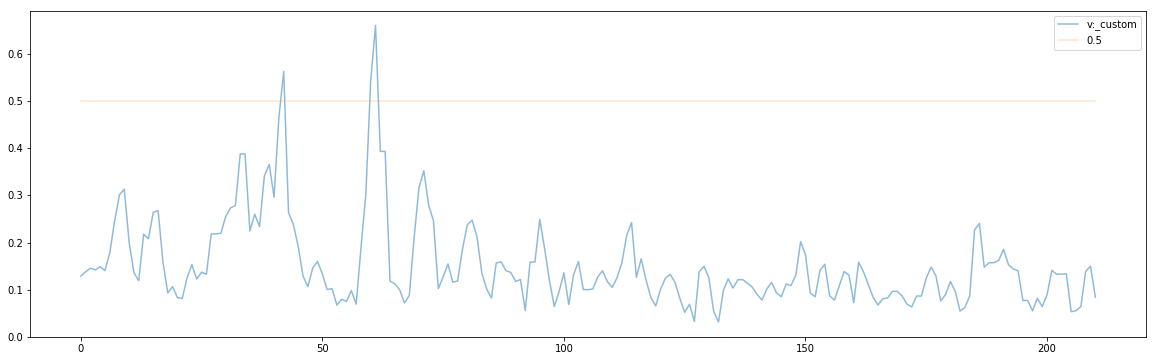

In [5]:
 
want_upload = False #@param {type:"boolean"}
search_for = "\u0437\u0430\u043B\u0435 \u0437\u0430" #@param {type:"string"}
from patterns import AbstractPatternFactory, FuzzyPattern

from text_tools import tokenize_text
import re
from text_normalize import normalize_text, replacements_regex
uploaded = """
Берлинская дада-ярмарка и Международная выставка сюрреализма в париж­ской галерее «Изящные искусства» в 1938 году стали высшими точками развития двух движений и подвели им итог. На «Сюрреалис­тической улице», за манекенами, выстроившимися в проходе в главный зал, располагались плакаты, приглашения, объявления и фотографии, отсылающие к ранним этапам сюрреализма. В главном зале, за оформление которого отвечал Марсель Дюшан 
 
, а за освеще­ние — Ман Рэй 
 
, картины 1920-х годов висели рядом с более ранними работами, что подчеркивало развити
е сюрреалистического «интернаци­она­ла». Зародившись как литературное течение, к концу 1930-х годов сюрреализм уже около 15 лет господствовал в художественном авангарде Парижа. Прежде чем пойти на спад с началом
Второй мировой войны, он стал частью светской культуры Парижа и даже до некотоРой
степени присягнул высокой моде, подобно тому как русский авангард — пусть совсем иначе — присягну 
в свое время революции. Изящество стиля, свойственное сюррелизму, способствоало этому 

­ сближению, которое, в свою очередь, упрочило положение многих представителей направления в обществе. 

Однако поначалу для литераторов и художников-бунтарей, ничуть не стремившихся к социаль­ному успеху, 
была куда более естественной связь с дадаизмом"""

#UNCOMMENT TO UPLOAD============================================================

 
if want_upload:
  uploaded = interactive_upload('Protocol')[0]
# 
_regex_addon = [
    (re.compile(r'[­]'), '-'),
]
TOKENS=tokenize_text( normalize_text(uploaded, replacements_regex+_regex_addon))



class PF(AbstractPatternFactory):
  def __init__(self):
    AbstractPatternFactory.__init__(self, None)
    self._build_ner_patterns()

  def _build_ner_patterns(self):
    def cp(name, tuples):
      return self.create_pattern(name, tuples)
   
    cp('_custom', ( '', search_for, ''))
    

# ---
pf = PF()

av = PM.find_patterns(text_tokens=TOKENS, patterns=pf.patterns)


 
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
for name in av.vectors:
  ax.plot(av.get_best(name, relu_th=0.8), label='v:'+name, alpha=0.5)
ax.plot([0.5]*av.size, label='0.5', alpha=0.2)
plt.legend(loc='upper right')



GLOBALS__['renderer'].render_color_text(TOKENS, av.get_by_name('_custom'), _range=(0,1) )
# TOKENS

In [6]:
%%time
av = PM.find_patterns(text_tokens=TOKENS, patterns=pf.patterns)
GLOBALS__['renderer'].render_color_text(TOKENS, av.get_by_name('_custom'), _range=(0,1) )

CPU times: user 983 ms, sys: 93.9 ms, total: 1.08 s
Wall time: 685 ms


In [7]:
%%time
av = PM.find_patterns_and_improved(text_tokens=TOKENS, patterns=pf.patterns)
GLOBALS__['renderer'].render_color_text(TOKENS, av.get_by_name('_custom'), _range=(0,1) )

CPU times: user 2.24 s, sys: 160 ms, total: 2.4 s
Wall time: 1.87 s


In [8]:
distances_to_center, distances_to_local_center = PM.get_distances_to_center(TOKENS)

GLOBALS__['renderer'].render_color_text(TOKENS, distances_to_center, _range=(0,1) )


In [9]:
from ml_tools import *
v = distances_to_center
v=relu(v, 0.5)
GLOBALS__['renderer'].render_color_text(TOKENS, v, _range=(0,1))


In [10]:
v2=relu(distances_to_local_center, 0.4)
GLOBALS__['renderer'].render_color_text(TOKENS, v2  )
